In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
path_to_folder = "ENPM673/tutorials/"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673/tutorials


###Importing Dependencies

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import convolve2d
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# Image Stiching

### Loading Images

In [5]:
# Load images
image1 = cv2.imread('assets/PA120272.JPG')
image2 = cv2.imread('assets/PA120273.JPG')
image3 = cv2.imread('assets/PA120274.JPG')
image4 = cv2.imread('assets/PA120275.JPG')

### Converting Images to Grayscale

In [7]:
# Convert images to grayscaled
gray1 = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
gray4 = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)

### Feature Extraction
Here, SIFT (Scale-Invariant Feature Transform) algorithm is used as the feature extractor. It is used in this case for the following reason:

1. Scale Invariance: SIFT features are scale-invariant, meaning they can detect and describe keypoints regardless of their scale within the image.

2. Rotation Invariance: SIFT features are also rotation-invariant, which means they can detect keypoints even if the object is rotated within the image.

3. Distinctiveness: SIFT features are designed to be distinctive, meaning they can accurately match corresponding keypoints between images even in the presence of occlusion, clutter, or changes in lighting conditions



**Note** - At the moment only image1 is displayed. Uncomment the following code to display all the images

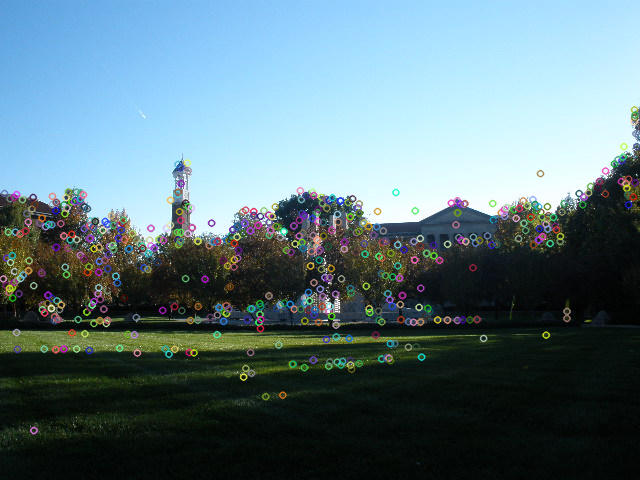

In [8]:
sift = cv2.SIFT_create()

#Finding keypoints and descriptors
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)
kp3, des3 = sift.detectAndCompute(gray3, None)
kp4, des4 = sift.detectAndCompute(gray4, None)

#Displaying the feature detected in image1
cv2_imshow(cv2.drawKeypoints(image1,kp1,None))

# #Uncomment the following to get the feature detected in image2, image3 and image4
# #Displaying the feature detected in image2
# cv2_imshow(cv2.drawKeypoints(image2,kp2,None))

# #Displaying the feature detected in image3
# cv2_imshow(cv2.drawKeypoints(image3,kp3,None))

# #Displaying the feature detected in image4
# cv2_imshow(cv2.drawKeypoints(image4,kp4,None))

### Feature Matching
Here FLANN is used for feature matching.
FLANN (Fast Library for Approximate Nearest Neighbors) is an efficient library for performing fast approximate nearest neighbor searches.

In [9]:
#feature matching
def match_features(descriptors1, descriptors2):

  # finding nearest match with KNN algorithm
  index_params = dict(algorithm=0, trees=5)
  search_params = dict(checks=50)

  flann = cv2.FlannBasedMatcher(index_params, search_params)

  Matches = flann.knnMatch(descriptors1, descriptors2, k=2)

  # Apply ratio test to get good matches
  good_matches = []
  for (m, n) in Matches:
      if m.distance < 0.5 * n.distance:
          good_matches.append(m)

  # Need to draw only good matches, so create a mask
  # This list is required for drawMatchesKnn()
  good_list = [[0, 0] for i in range(len(Matches))]

  for i, (j, k) in enumerate(Matches):
      if j.distance < 0.5*k.distance:
          good_list[i] = [1, 0]

  return Matches, good_matches, good_list

t_matches1_2, g_matches1_2,g_list1_2= match_features(des1, des2)
t_matches2_3, g_matches2_3,g_list2_3 = match_features(des2, des3)
t_matches3_4, g_matches3_4,g_list3_4 = match_features(des3, des4)



### Displaying the Feature Matching
cv2.drawMatchesKnn() is used to display feature matching

**Note** - At the moment only image1_2 is displayed. Uncomment the following code to display all the images

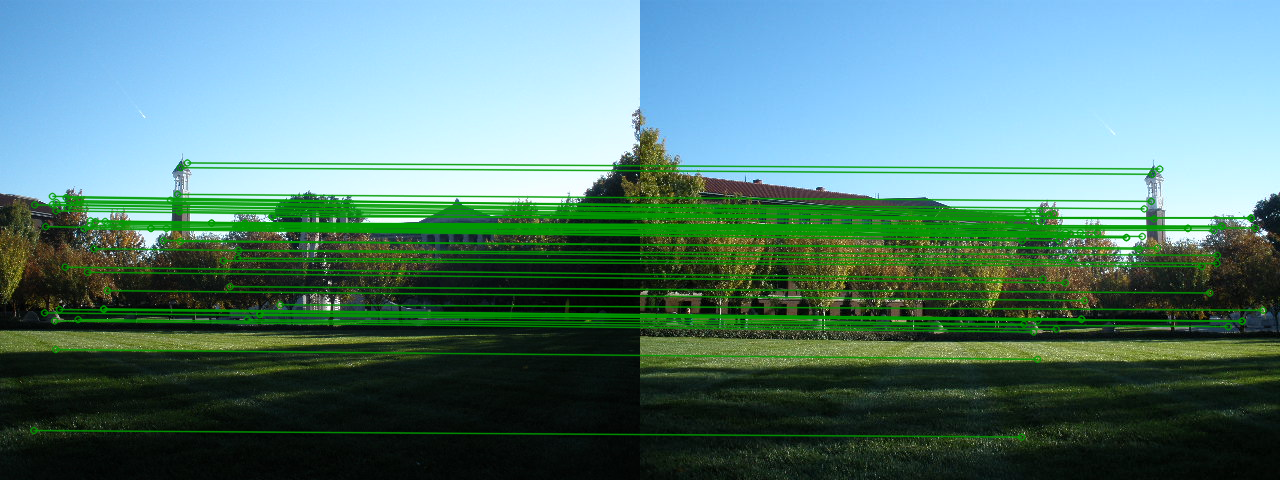

In [10]:
#Displaying featuring matching in image1 and image2
Matched_1_2 = cv2.drawMatchesKnn(image1,
                             kp1,
                             image2,
                             kp2,
                             t_matches1_2,
                             outImg=None,
                             matchColor=(0, 155, 0),
                             singlePointColor=None,
                             matchesMask=g_list1_2,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                             )
cv2_imshow(Matched_1_2)

# #Uncomment to Display feature matching in image2 - image3 and image3 - image4
# #Displaying featuring matching in image2 and image3
# Matched_2_3 = cv2.drawMatchesKnn(image2,
#                              kp2,
#                              image3,
#                              kp3,
#                              t_matches2_3,
#                              outImg=None,
#                              matchColor=(0, 155, 0),
#                              singlePointColor=None,
#                              matchesMask=g_list2_3,
#                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
#                              )

# cv2_imshow(Matched_2_3)

# #Displaying featuring matching in image3 and image4
# Matched_3_4 = cv2.drawMatchesKnn(image3,
#                              kp3,
#                              image4,
#                              kp4,
#                              t_matches3_4,
#                              outImg=None,
#                              matchColor=(0, 155, 0),
#                              singlePointColor=None,
#                              matchesMask=g_list3_4,
#                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
#                              )

# cv2_imshow(Matched_3_4)

### Calculating Homography
Homography is a transformation that maps the points in one point to the corresponding point in another image.

In [11]:
def compute_homography(keypoints1, keypoints2, matches):


    # maintaining list of index of descriptors in query descriptors
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)

    # maintaining list of index of descriptors in train descriptors
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # finding  perspective transformation
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    return H

hg_1_2 = compute_homography(kp1,kp2, g_matches1_2)
hg_2_3 = compute_homography(kp2, kp3, g_matches2_3)
hg_3_4 = compute_homography(kp3, kp4, g_matches3_4)

#Displaying the homography matrix for image1 and image2
print("Homography Matrix for image1 and image2")
print(hg_1_2)

#Displaying the homography matrix for image1 and image2
print("\n Homography Matrix for image2 and image3")
print(hg_2_3)

#Displaying the homography matrix for image1 and image2
print("\n Homography Matrix for image3 and image4")
print(hg_3_4)

Homography Matrix for image1 and image2
[[ 8.45361748e-01  5.87413043e-02  3.29039034e+02]
 [-1.12103597e-01  9.79548597e-01  2.28274865e+01]
 [-2.69961155e-04  3.88967658e-05  1.00000000e+00]]

 Homography Matrix for image2 and image3
[[ 8.87142941e-01  6.87957036e-02  2.65792258e+02]
 [-1.08124843e-01  9.69035896e-01  2.68336241e+01]
 [-1.85218706e-04 -1.48561693e-05  1.00000000e+00]]

 Homography Matrix for image3 and image4
[[ 8.91915606e-01  4.81526710e-02  2.87754587e+02]
 [-9.41296090e-02  9.73636012e-01  2.09288433e+01]
 [-1.85958383e-04 -7.47100328e-06  1.00000000e+00]]


### Stitching the Images

In [12]:
def combine_images(image1, image2, H):
    # Get dimensions of the input images
    height1, width1 = image1.shape[:2]
    height2, width2 = image2.shape[:2]

    # Warp the first image using the homography matrix
    warped_image1 = cv2.warpPerspective(image1, H, (width2 + width1, height2))

    # Combine the warped image and the second image
    combined_img = np.zeros((height2, width1 + width2, 3), dtype=np.uint8)
    combined_img[:height2, :width2] = image2
    combined_img[:height1, width2:] = warped_image1[:height1, width2:]

    return combined_img

#Calling the  combine_images function
combined_img_1_2 = combine_images(image1, image2, hg_1_2)
combined_img_2_3 = combine_images(combined_img_1_2, image3, hg_2_3)
combined_img_3_4 = combine_images(combined_img_2_3, image4, hg_3_4)

### Displaying the Stitched Image

**Note** - At the moment only the final combined image is displayed. Uncomment the following code to display all the images

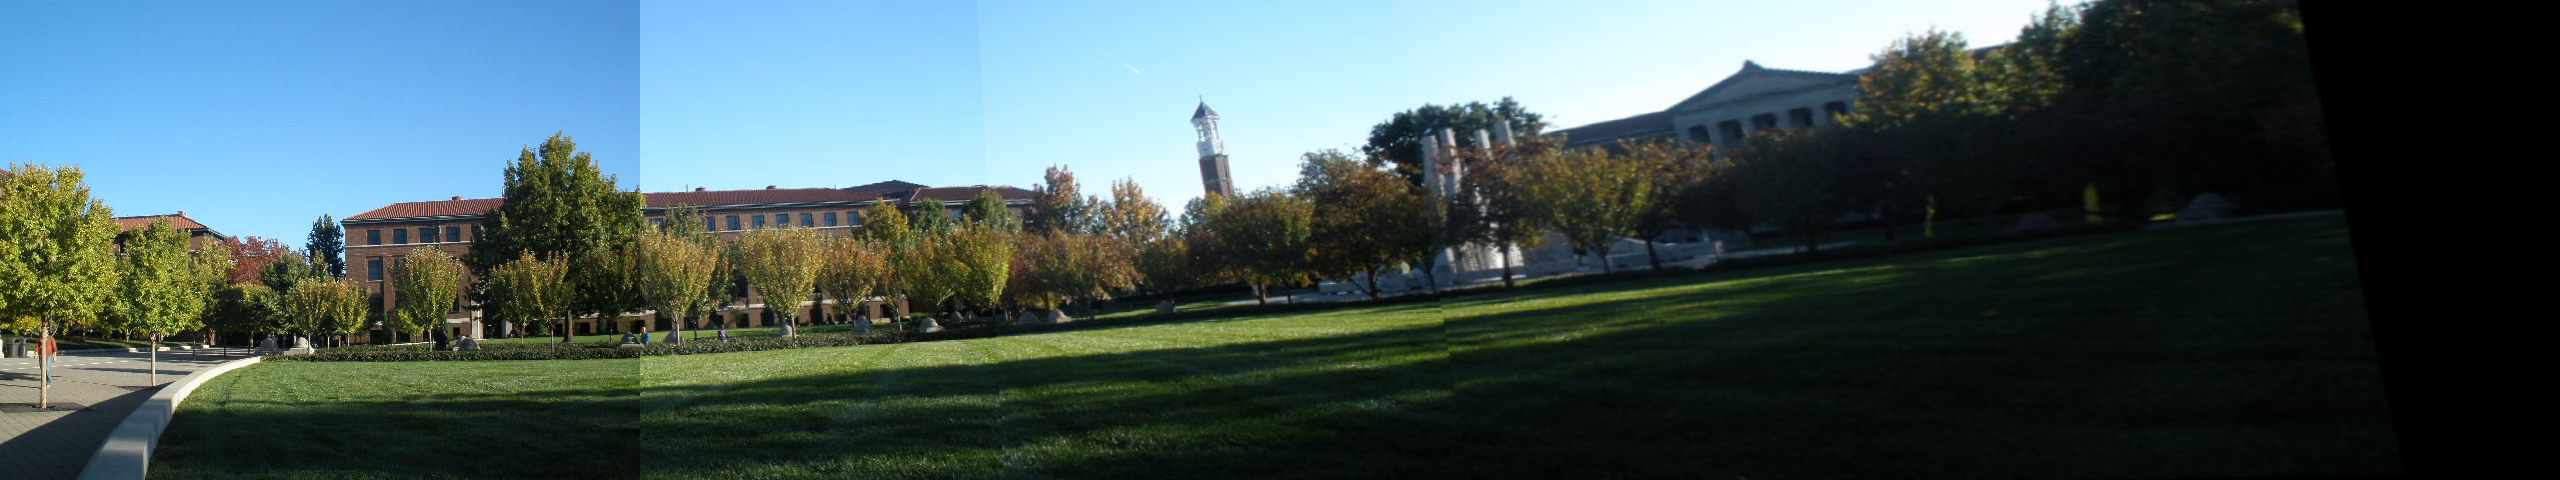

In [13]:
# #Uncomment following to display images
# # Stitching image1 and image2
# cv2_imshow(combined_img_1_2)

# # Stitching image2 and image3
# cv2_imshow(combined_img_2_3)

# Final Stitched Image
cv2_imshow(combined_img_3_4)


**Question :** In general, why does panoramic mosaicing work better when the camera is only allowed to rotate at its camera center?


Panoramic mosaicing refers to the process of stitching together multiple images captured from a single viewpoint but covering different parts of a scene to create a wide-angle or panoramic view. Allowing only rotation about the camera center has several advantages for panoramic mosaicing:

1. **Reduced Parallax Errors:** Parallax occurs when objects at different depths appear to shift relative to each other as the viewpoint changes. When the camera rotates around its center, parallax errors are minimized because the relative positions of objects within the scene remain relatively stable. This results in better alignment of features across images, leading to smoother and more accurate stitching.

2. **Consistent Scale and Perspective:** Rotating the camera about its center ensures that the scale and perspective of the captured images remain consistent across the entire scene. This consistency is essential for creating visually pleasing and accurate panoramic images without distortions or inconsistencies in scale or perspective.

3. **Simplified Homography Estimation:** Homography estimation, which is crucial for aligning images during panoramic stitching, becomes simpler when the camera rotates about its center. In this scenario, the homography matrix essentially becomes a rotation matrix, which can be easily computed using geometric transformations. This simplifies the computational process and reduces the risk of errors in estimating the transformation between images.

Overall, rotating the camera about its center facilitates optimal stitching results.